In [1]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [2]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [3]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [4]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [5]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [6]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  205
Number of links for Episode V:  148
Number of links for Episode VI:  153


In [7]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  506


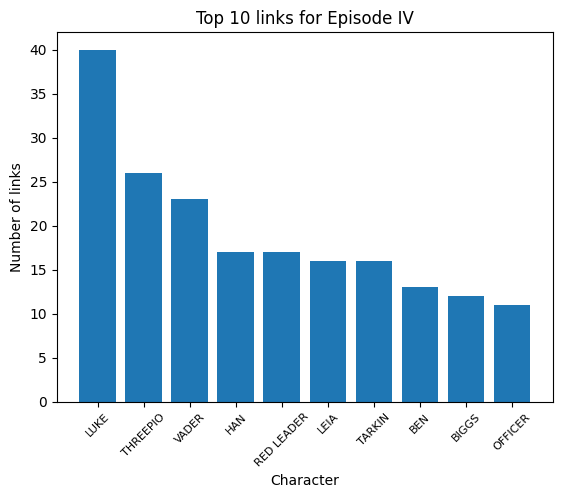

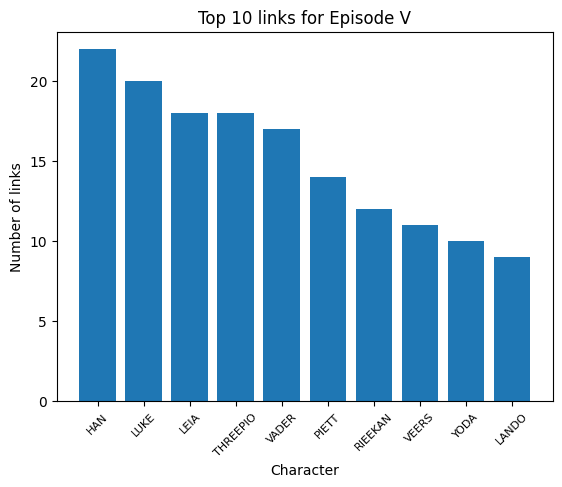

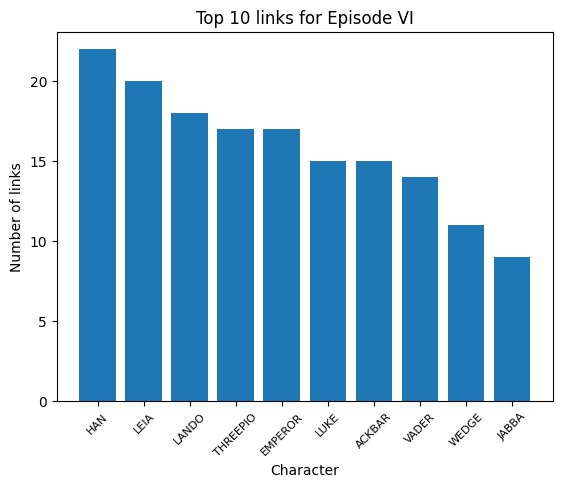

In [8]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time:

In [9]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        all_nodes.append(nodes_for_each_ep[:])
        all_links.append(links_for_each_ep[:])
    print("Nodes: ", [len(node) for node in all_nodes])
    print("Links: ", [len(link) for link in all_links])
    return all_nodes, all_links

def number_of_links_lst(all_nodes, all_links):
    return [len(node) for node in all_nodes], [len(link) for link in all_links]

In [10]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, font_size = 5, ax=axs[i])
        #plt.title(f"Episode {i+4}")
        #plt.show()
        axs[i].set_title(f'Episode {i+1}')

nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)
print(*[(len(node), len(link)) for node, link in zip(nodes_for_each_ep, links_for_each_ep)], sep="\n")

Nodes:  [43, 65, 82]
Links:  [43, 65, 82]
(43, 43)
(65, 65)
(82, 82)


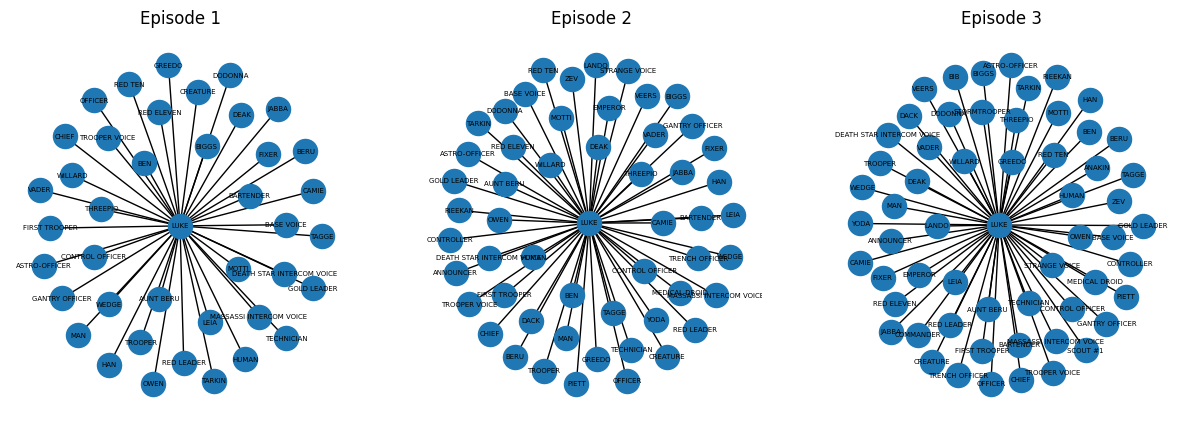

In [11]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
luke_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

We will now replicate for Threepio:

Nodes:  [30, 51, 69]
Links:  [30, 51, 69]


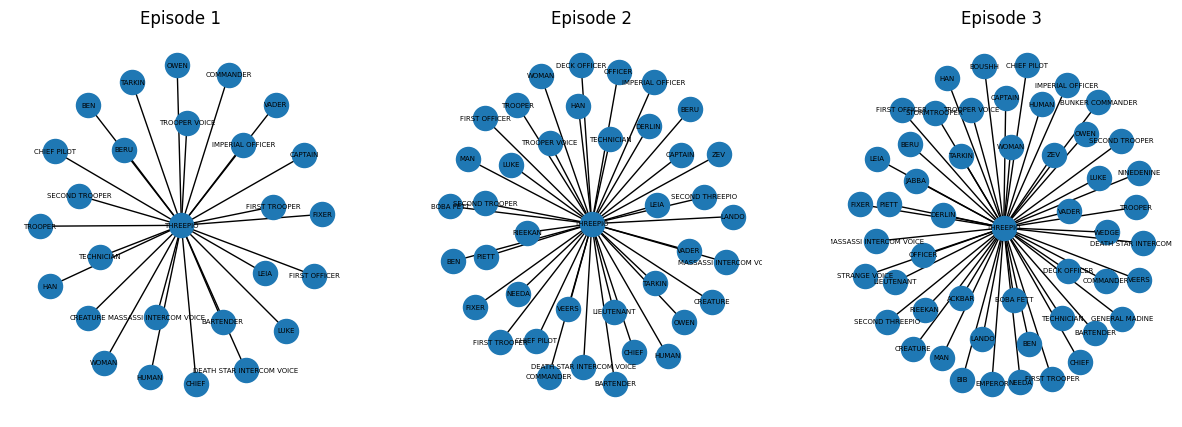

In [12]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("threepio", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
threepio_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

Here it is obvious that both Luke and C-3PO (ThreePio) develop a 

In [13]:
def procent_rise(args):
    nodes, links = args
    nodes_percentage = [round((node - nodes[0])/nodes[0]*100, 4) for node in nodes]
    links_percentage = [round((link - links[0])/links[0]*100, 4) for link in links]
    print("Rise in nodes: ", nodes_percentage)
    print("Rise in links: ", links_percentage)
    return nodes_percentage, links_percentage

print("Luke: ")
procent_rise(luke_len)
print("\nThreepio: ")
procent_rise(threepio_len)

Luke: 
Rise in nodes:  [0.0, 51.1628, 90.6977]
Rise in links:  [0.0, 51.1628, 90.6977]

Threepio: 
Rise in nodes:  [0.0, 70.0, 130.0]
Rise in links:  [0.0, 70.0, 130.0]


([0.0, 70.0, 130.0], [0.0, 70.0, 130.0])

## Word Frequency

In [15]:
dialogues = [ep["dialogue"].values for ep in cleaned_episodes]
dialogues[0]

array(["Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!",
       "We're doomed!",
       "There'll be no escape for the Princess this time.", ...,
       "We'll get to work on him right away.",
       "You must repair him!  Sir, if any of my circuits or gears will help, I'll gladly donate them.",
       "He'll be all right."], dtype=object)

In [21]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation
from collections import Counter, defaultdict
from statistics import mode
import numpy as np

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()

# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit(): # Remove digits
                continue
            elif token in punctuation or token in ["'s","'re","'ve","'ll",] or token in stopwords: # Remove punctuation and stopwords
                continue
            elif any(symbol in token for symbol in ["`","’",".","--"]):
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

In [62]:
from nltk.corpus import brown
text_brown = " ".join(brown.words(categories="news"))
text_brown_tokens = get_tokens(text_brown)
    
def func():
    for i in range(0, len(text_brown_tokens), 10_500):
        yield text_brown_tokens[i:i + 10_500]

texts = [(" ".join(dialogue)).lower() for dialogue in dialogues]
documents = list(map(get_tokens, texts)) + list(func())
number_of_documents = len(documents)

# Tokenizing the entire corpus:
star_wars_vocab = word_tokenize(" ".join(texts).lower())
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# TF and IDF formulas:
IDF = lambda term_count: np.log10(number_of_documents / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum([list(set(tokens)) for tokens in documents], [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

# Function to calculate the word-frequency-dictionaries for each group in a list of communities:
def get_TF_IDF(communities, single=False):
    if single: communities = [communities]
    
    community_TF_IDF = []
    for group in communities:
        group_total_tokens = sum(group["tokens"], []) # Adding all tokens of the group together.
        group_total_tokens_count = Counter(group_total_tokens)
        
        # Calculating the TF-IDF and making it into a dictionary:
        tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
        community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
    if single: return community_TF_IDF[0]
    return community_TF_IDF

In [63]:
sum(documents, [])
tokens_sw2 = list(map(get_tokens, texts))

dict1 = []
for i in tokens_sw2:
    docs_counter = Counter(i)
    tf_idf = {token_beautifier(word): TF(count, len(i)) * IDF_dict[word] for word, count in docs_counter.items()}
    dict1.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))

In [64]:
first_n_dict = lambda dicter, n: {k: dicter[k] for k in list(dicter)[:n]}
first_n_dict(dict1[0], 10)

{'luke': 0.34682123712861923,
 'kenobi': 0.30888766431767645,
 'sir': 0.24927776418619507,
 'alderaan': 0.216763273205387,
 'droid': 0.2147097120364333,
 'oh': 0.1763686920299274,
 'biggs': 0.16257245490404024,
 'planet': 0.16257245490404024,
 'artoo': 0.14569587602472261,
 'obi-wan': 0.14569587602472261}

C:\Users\alexa\AppData\Local\Temp\ipykernel_11768\1344172804.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11768\1344172804.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11768\1344172804.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)


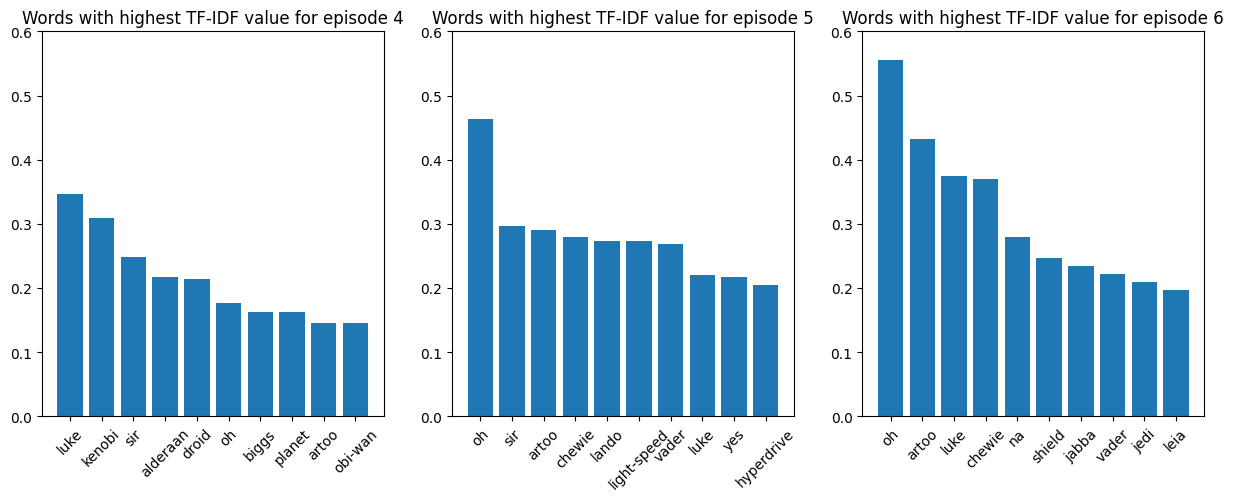

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    common_words = list(dict1[i].keys())[:10]
    word_freq = list(dict1[i].values())[:10]

    axs[i].bar(common_words, word_freq)
    axs[i].set_title(f"Words with highest TF-IDF value for episode {i+4}")
    axs[i].set_xticklabels(common_words, rotation=45)
    axs[i].set_ylim(0, 0.6)
    # axs[i].set_ylabel("Frequency")
    # axs[i].get_yaxis().set_visible(False)